In [1]:
import os, pickle, cloudpickle
import pandas as pd
import numpy as np
import shapely, shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os.path as path


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# specify number of stations want to increase
NUM_STATIONS_INC = 1

In [3]:
# specify dir
CITY = "C_"
save_dir = CITY + 'clas_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')


In [4]:
# load unmitigated random forest
with open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb') as file:  
    rf_best = pickle.load(file)

# load exponentiated gradient
with open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb') as file:  
    eg_best = cloudpickle.load(file)

# load grid search
with open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb') as file:  
    gs_best = pickle.load(file)

In [5]:
# load necessary datasets
df_all = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_all.csv"), index_col = 0)
df_weather = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_weather.csv"), index_col = 0)
df_weather.year = df_weather.year.astype(int)
df_weather.month = df_weather.month.astype(int)
X_train = pd.read_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"), index_col = 0)
df_geo = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_geo.csv"), index_col = 0)
for row,col in df_geo.iterrows():
    df_geo.at[row, 'geometry'] = shapely.wkt.loads(df_geo.loc[row]['geometry'])
df_geo = df_geo[["cell_num", "geometry", "centroid"]]

In [6]:
df_geo

,cell_num,geometry,centroid
0,104,POLYGON ((-85.46347245413803 34.98311234314082...,POINT (-85.46117705986944 34.98540773740939)
1,105,POLYGON ((-85.46347245413803 34.98770313167797...,POINT (-85.46117705986944 34.98999852594654)
2,156,POLYGON ((-85.45888166560087 34.98311234314082...,POINT (-85.4565862713323 34.98540773740939)
3,157,POLYGON ((-85.45888166560087 34.98770313167797...,POINT (-85.4565862713323 34.98999852594654)
4,158,POLYGON ((-85.45888166560087 34.99229392021512...,POINT (-85.4565862713323 34.99458931448369)
...,...,...,...
1825,4651,POLYGON ((-85.06407385140531 35.08870047949528...,POINT (-85.06177845713674 35.09099587376386)
1826,4652,POLYGON ((-85.06407385140531 35.09329126803243...,POINT (-85.06177845713674 35.095586662301)
1827,4704,POLYGON ((-85.05948306286815 35.09329126803243...,POINT (-85.05718766859957 35.095586662301)
1828,4705,POLYGON ((-85.05948306286815 35.09788205656958...,POINT (-85.05718766859957 35.10017745083816)


In [7]:
# duplicate rows 
df_forc = pd.DataFrame(np.repeat(df_all.values, 12, axis=0))
df_forc.columns = df_all.columns
int_col = ["cell_num", "tract_id", "stations", "capacity", "total_population",
           "total_housing_units", "median_income", "walk_score", "bike_score", "transit_score",
           "population_over_16", "population_over_16_employed", "population_over_16_unemployed",
           "nearby_bus", "nearby_rail", "nearby_other", "nearby_routes"]
for col in int_col:
    df_forc[col] = df_forc[col].astype(int)
    
# load weather
df_weather_19 = df_weather[df_weather.year == 2019]

# attach weather & month
for index, col in df_forc.iterrows():
    curr_month = index%12 + 1
    
    df_forc.at[index, "month"] = curr_month
    df_forc.at[index, "weather"] = df_weather_19[df_weather_19.month == curr_month].weather.values[0]

df_forc.month = df_forc.month.astype(int)

# save cell_num
cell_num = df_forc["cell_num"]
df_forc.drop(columns = "cell_num", inplace = True)

df_forc.head()

,tract_id,stations,capacity,total_population,total_housing_units,median_income,white_pct,black_pct,hispanic_pct,mean_travel_time_to_work,...,population_over_16_unemployed,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,month,weather
0,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,1,43.1
1,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,2,51.1
2,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,3,51.6
3,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,4,64.1
4,47065012100,0,0,6556,2922,59507,86.790726,8.221477,1.082977,19.581443,...,71,0,0,0,0,0,0,0,5,74.2


In [8]:
# select feature
df_forc.drop(columns = ['white_pct', 'black_pct', 'hispanic_pct', 'population_over_16', 
                   'pct_total_car_truck_van', "pct_bicycle", "tract_id"], inplace = True)

In [9]:
# training set
df_forc["income_group"] = 0

for row, col in df_forc.iterrows():
    
    if df_forc.loc[row]["median_income"] > 50000:
        df_forc.at[row, "income_group"] = 1
        
df_forc.drop(columns = ["median_income"], inplace = True)

# sns.countplot("income_group", data = df_forc)
# plt.title("Distribution of income")

In [10]:
# match order
df_forc = df_forc[X_train.columns]

In [11]:
# # scale
# columns_new = list(df_forc.columns)
# columns_new.remove('income_group')

# min_max_scaler = preprocessing.MinMaxScaler()
# df_scaled = min_max_scaler.fit_transform(df_forc.drop(columns = ['income_group']))
# df_scaled = pd.DataFrame(df_scaled, columns = columns_new)

# df_scaled["income_group"] = df_forc["income_group"]
# # df_scaled["stations"] = df["stations"]
# # df_scaled.outflow = min_max_scaler.fit_transform(df_scaled.outflow.values.reshape(-1, 1))
# df_forc = df_scaled

### prediction

In [12]:
# ## old prediction
# old_pred_random_forest = rf_best.predict(df_forc)
# old_pred_exp_grad = eg_best.predict(df_forc, random_state = 42)
# old_pred_grid_search = gs_best.predict(df_forc)

In [13]:
# increase stations by NUM_STATIONS_INC, then scale
df_forc_new = df_forc.copy()
df_forc_new["stations"] += NUM_STATIONS_INC

In [14]:
## new prediction
new_pred_random_forest = rf_best.predict(df_forc_new)
new_pred_exp_grad = eg_best.predict(df_forc_new, random_state = 42)
new_pred_grid_search = gs_best.predict(df_forc_new)

In [15]:
pred_df = cell_num.to_frame()
pred_df["month"] = df_forc_new["month"]
pred_df["income_group"] = df_forc_new["income_group"]
# pred_df["stations_added"] = df_forc_new["stations"]

In [16]:
pred_df["stations_added"] = df_forc_new["stations"]

In [17]:
cell_num2stations_df = pred_df.groupby("cell_num").mean().reset_index()[["cell_num", "stations_added"]]
# cell_num2stations_df.stations_added = cell_num2stations_df.stations_added.astype(int)
cell_num2stations_df

,cell_num,stations_added
0,104,1.0
1,105,1.0
2,156,1.0
3,157,1.0
4,158,1.0
...,...,...
1825,4651,1.0
1826,4652,1.0
1827,4704,1.0
1828,4705,1.0


In [18]:
pred_df["new_pred_random_forest"] = new_pred_random_forest
pred_df["new_pred_exp_grad"] = new_pred_exp_grad
pred_df["new_pred_grid_search"] = new_pred_grid_search

In [19]:
pred_df

,cell_num,month,income_group,stations_added,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search
0,104,1,1,1,0,0,0
1,104,2,1,1,0,0,0
2,104,3,1,1,0,0,0
3,104,4,1,1,1,1,1
4,104,5,1,1,1,1,1
...,...,...,...,...,...,...,...
21955,4758,8,1,1,1,1,1
21956,4758,9,1,1,1,1,1
21957,4758,10,1,1,1,0,1
21958,4758,11,1,1,0,0,0


In [20]:
pred_df_yearly = pred_df.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
pred_df_yearly

,cell_num,income_group,stations_added,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search
0,104,12,12,6,6,3
1,105,12,12,6,6,3
2,156,12,12,6,6,3
3,157,12,12,6,6,3
4,158,12,12,6,6,3
...,...,...,...,...,...,...
1825,4651,12,12,7,7,0
1826,4652,12,12,7,7,0
1827,4704,12,12,7,6,7
1828,4705,12,12,7,6,7


In [21]:
# attach # of stations info

pred_df_yearly = pred_df_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_random_forest_yearly = pred_random_forest_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_exp_grad_yearly = pred_exp_grad_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_grid_search_yearly = pred_grid_search_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')

In [22]:
pred_df_yearly_geo = pred_df_yearly.merge(df_geo, on = "cell_num", how = "left")
pred_df_yearly_geo = gpd.GeoDataFrame(pred_df_yearly_geo, crs='EPSG:2956', geometry='geometry')

### visualize

In [23]:
pred_df_yearly_geo["income_group"] = pred_df_yearly_geo["income_group"].apply(lambda x: "high_income" if x == 12 else "low_income")

In [24]:
pred_df_yearly_geo = gpd.GeoDataFrame(pred_df_yearly_geo, crs='EPSG:2956', geometry='geometry')

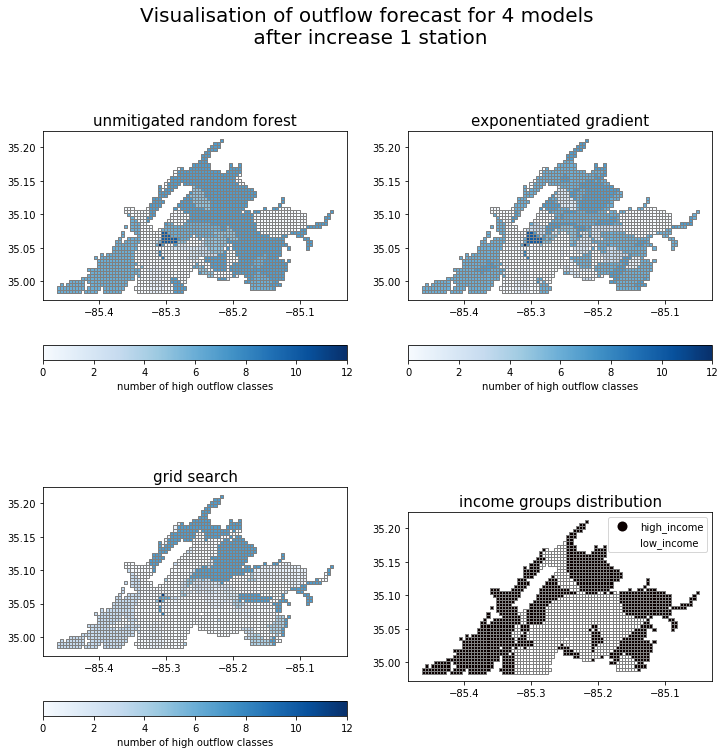

In [25]:
# grid search
fig, axes = plt.subplots(2,2, figsize = (12, 12))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]

pred_df_yearly_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax1)
ax1.set_title("unmitigated random forest", fontsize=15)

pred_df_yearly_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax2)
ax2.set_title("exponentiated gradient", fontsize=15)

pred_df_yearly_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "number of high outflow classes",'orientation': "horizontal"}, ax = ax3)
ax3.set_title("grid search", fontsize=15)

pred_df_yearly_geo.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = ax4)
ax4.set_title("income groups distribution", fontsize=15)

fig.suptitle(('Visualisation of outflow forecast for 4 models\n after increase {} station').format(NUM_STATIONS_INC), fontsize=20)

FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

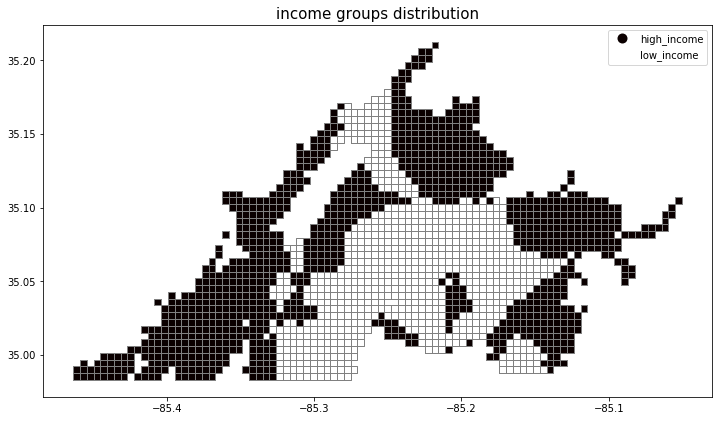

In [28]:
fig, axes = plt.subplots(figsize = (12, 12))
pred_df_yearly_geo.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = axes)
axes.set_title("Chattanooga", fontsize=15)
FIG_NAME = "income_group_distribution"
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

### Analysis

In [29]:
def forecast_res_calc(pred_df_yearly_geo):
    
    high_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "high_income"]
    low_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "low_income"]

    random_forest_diff =  ((low_inc.new_pred_random_forest.sum())/len(low_inc)) / ((high_inc.new_pred_random_forest.sum())/len(high_inc))
    exp_grad_diff =  ((low_inc.new_pred_exp_grad.sum())/len(low_inc)) / ((high_inc.new_pred_exp_grad.sum())/len(high_inc))
    grid_search_diff =  ((low_inc.new_pred_grid_search.sum())/len(low_inc)) / ((high_inc.new_pred_grid_search.sum())/len(high_inc))

    return random_forest_diff, exp_grad_diff, grid_search_diff

In [30]:
FILE_NAME = "forc_res_summary.csv"

PATH1 = os.path.join(save_dir_forecast, CITY + FILE_NAME)

if path.exists(PATH1):
    forc_res_summary = pd.read_csv(PATH1, index_col = 0)
else:
    forc_res_summary = pd.DataFrame(0, columns = ["random_forest_ratio", "exp_grad_ratio", "grid_search_ratio"], index = ["inc_{}_station".format(NUM_STATIONS_INC)])

In [34]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "random_forest_ratio"] = forecast_res_calc(pred_df_yearly_geo)[0]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "exp_grad_ratio"] = forecast_res_calc(pred_df_yearly_geo)[1]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "grid_search_ratio"] = forecast_res_calc(pred_df_yearly_geo)[2]

In [35]:
forc_res_summary.to_csv(os.path.join(save_dir_forecast, CITY + FILE_NAME))
forc_res_summary

,random_forest_ratio,exp_grad_ratio,grid_search_ratio
inc_1_station,0.9929,0.813808,0.655001
